<a href="https://colab.research.google.com/github/s34836/WUM/blob/main/Lab_12_Object_Classification_and_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Classification and Localization

## Tasks
1. See an example of a network designed to classify and localize objects [here](https://github.com/camara94/object-localization-tensorflow/blob/main/project/Object_Localization_with_TensorFlow_Complete.ipynb).
2. The `CALTECH.zip` file contains a dataset of images dividend into three classes and with assigned bounding boxes (in `labels.csv`). Load the images, labels and bounding box coordinates. To classify the images and localize objects, create a convolutional network with two output layers - one for classes and one for coordinates. Due to limited training data, for this task it is best to use a pre-trained model, for example MobileNetV2.

In [1]:

!unzip -q CALTECH.zip
!ls

CALTECH  CALTECH.zip  sample_data


In [30]:

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

images = tf.keras.preprocessing.image_dataset_from_directory("CALTECH/CALTECH_Dataset", shuffle=False, label_mode=None, batch_size=None, image_size=(224, 224))
images = np.stack([image.numpy() for image in images])
images = (images / 255.0) * 2.0 - 1.0  # Scale images to [-1, 1]

# Load and scale bounding boxes
labels = pd.read_csv("CALTECH/labels.csv")
im_width = labels['width']
im_height = labels['height']
bounding_boxes = labels.iloc[:, -4:]
bounding_boxes['xmin'] = bounding_boxes['xmin'] / im_width
bounding_boxes['xmax'] = bounding_boxes['xmax'] / im_width
bounding_boxes['ymin'] = bounding_boxes['ymin'] / im_height
bounding_boxes['ymax'] = bounding_boxes['ymax'] / im_height
bounding_boxes = bounding_boxes.to_numpy()

class_targets = labels['class'].astype('category').cat.codes.to_numpy()

X_train, X_test, bbox_train, bbox_test, labels_train, labels_test = train_test_split(images, bounding_boxes, class_targets, test_size=0.2, random_state=42)

Found 218 files.


In [31]:
# liczba klas (musi być przed Dense)
num_classes = labels['class'].astype('category').cat.categories.size

# Model: MobileNetV2 + 2 wyjścia (klasa + bbox)
base = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg",
)
base.trainable = False  # zamrażamy na start

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base(inputs, training=False)

# głowica klasyfikacji
class_out = tf.keras.layers.Dense(num_classes, activation="softmax", name="class_out")(x)

# głowica bbox (0..1)
bbox_out = tf.keras.layers.Dense(4, activation="sigmoid", name="bbox_out")(x)

model = tf.keras.Model(inputs, outputs={"class_out": class_out, "bbox_out": bbox_out})

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "class_out": tf.keras.losses.SparseCategoricalCrossentropy(),
        "bbox_out": tf.keras.losses.Huber(delta=0.05),
    },
    loss_weights={"class_out": 1.0, "bbox_out": 5.0},
    metrics={
        "class_out": ["accuracy"],
        "bbox_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
    },
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ input_layer_9[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_out (Dense)    │ (None, 4)         │      5,124 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_out (Dense)   │ (None, 3)         │      3,843 │ mobilenetv2_1.00… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
# Trening + ewaluacja
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train,
    {
        "class_out": labels_train,
        "bbox_out": bbox_train,
    },
    validation_data=(
        X_test,
        {
            "class_out": labels_test,
            "bbox_out": bbox_test,
        },
    ),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(
    X_test,
    {
        "class_out": labels_test,
        "bbox_out": bbox_test,
    }
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - bbox_out_loss: 0.0137 - bbox_out_mae: 0.3004 - class_out_accuracy: 0.4372 - class_out_loss: 1.0870 - loss: 1.1648 - val_bbox_out_loss: 0.0040 - val_bbox_out_mae: 0.0984 - val_class_out_accuracy: 0.7500 - val_class_out_loss: 0.6653 - val_loss: 0.6837
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - bbox_out_loss: 0.0036 - bbox_out_mae: 0.0926 - class_out_accuracy: 0.9117 - class_out_loss: 0.4580 - loss: 0.4784 - val_bbox_out_loss: 0.0026 - val_bbox_out_mae: 0.0756 - val_class_out_accuracy: 0.9545 - val_class_out_loss: 0.2722 - val_loss: 0.3072
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - bbox_out_loss: 0.0030 - bbox_out_mae: 0.0792 - class_out_accuracy: 0.9675 - class_out_loss: 0.2228 - loss: 0.2389 - val_bbox_out_loss: 0.0027 - val_bbox_out_mae: 0.0790 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.1415 - val_loss: 0.1708
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - bbox_out_loss: 0.0031 - bbox_out_mae: 0.0822 - class

[0.027539072558283806,
 0.01534184254705906,
 0.0022829740773886442,
 0.0683223083615303,
 1.0]

['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
BBox columns assumed: ['xmin', 'ymin', 'xmax', 'ymax']

Sample 0
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.28033474), np.float32(0.06666667), np.float32(0.92050207), np.float32(0.9266667)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.21434808), np.float32(0.060589384), np.float32(0.8883849), np.float32(0.93787616)]


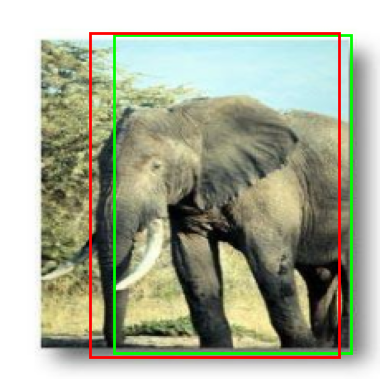


Sample 1
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.09677419), np.float32(0.046666667), np.float32(0.97235024), np.float32(0.87666667)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.14678547), np.float32(0.1019067), np.float32(0.8909933), np.float32(0.89221615)]


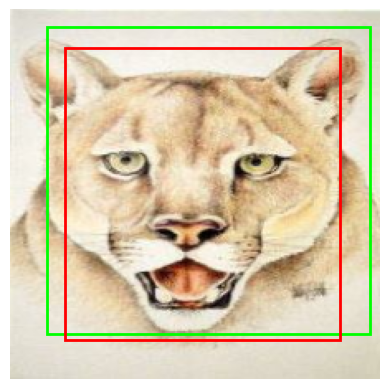


Sample 2
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.26), np.float32(0.12777779), np.float32(0.93333334), np.float32(0.98888886)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.14431576), np.float32(0.020238698), np.float32(0.9680446), np.float32(0.9199858)]


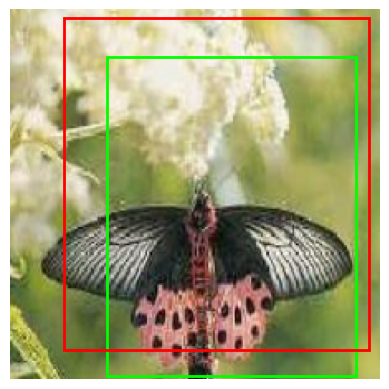


Sample 3
TRUE bbox [xmin,ymin,xmax,ymax]: [np.float32(0.043333333), np.float32(0.1384083), np.float32(0.99333334), np.float32(0.9411765)]
PRED bbox [xmin,ymin,xmax,ymax]: [np.float32(0.081248835), np.float32(0.011234056), np.float32(0.9677101), np.float32(0.9325418)]


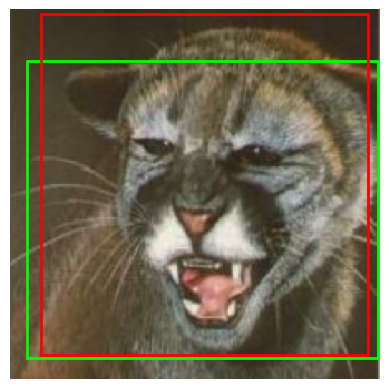

In [33]:
# kontrola predykcji bbox dla 1 batcha
import matplotlib.pyplot as plt

# pokaż nazwy kolumn, żeby zweryfikować kolejność bbox
print(labels.columns.tolist())
print("BBox columns assumed:", bbox.columns.tolist() if isinstance(bbox, pd.DataFrame) else labels.columns[-4:].tolist())

for images, targets in test_ds.take(1):
    preds = model.predict(images, verbose=0)

    pred_bb = preds["bbox_out"]
    true_bb = targets["bbox_out"].numpy()

    imgs = (images.numpy() + 1.0) / 2.0  # back to [0,1]

    for i in range(min(4, imgs.shape[0])):
        h, w = imgs[i].shape[0], imgs[i].shape[1]
        tx1, ty1, tx2, ty2 = true_bb[i]
        px1, py1, px2, py2 = pred_bb[i]

        print(f"\nSample {i}")
        print("TRUE bbox [xmin,ymin,xmax,ymax]:", [tx1, ty1, tx2, ty2])
        print("PRED bbox [xmin,ymin,xmax,ymax]:", [px1, py1, px2, py2])

        plt.figure()
        plt.imshow(imgs[i])
        plt.axis("off")

        # TRUE - zielony
        plt.gca().add_patch(
            plt.Rectangle((tx1*w, ty1*h), (tx2-tx1)*w, (ty2-ty1)*h,
                          fill=False, linewidth=2, edgecolor="lime")
        )
        # PRED - czerwony
        plt.gca().add_patch(
            plt.Rectangle((px1*w, py1*h), (px2-px1)*w, (py2-py1)*h,
                          fill=False, linewidth=2, edgecolor="red")
        )
        plt.show()
    break

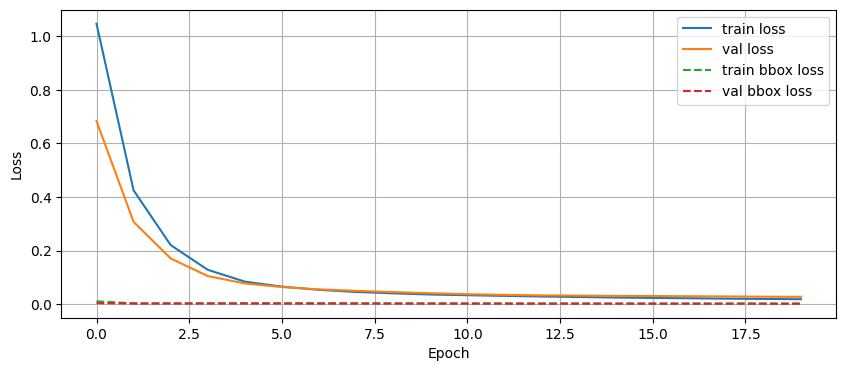

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# loss całkowity
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")

# loss bbox
plt.plot(history.history["bbox_out_loss"], label="train bbox loss", linestyle="--")
plt.plot(history.history["val_bbox_out_loss"], label="val bbox loss", linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

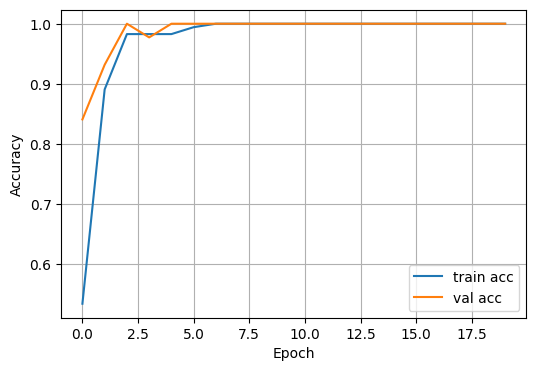

In [29]:
plt.figure(figsize=(6,4))
plt.plot(history.history["class_out_accuracy"], label="train acc")
plt.plot(history.history["val_class_out_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()